# 🖼️ Multimodal Image Captioning with BLIP (Bootstrapping Language-Image Pre-training)

**Dataset**: [Flickr8k (adityajn105 on Kaggle)](https://www.kaggle.com/datasets/adityajn105/flickr8k)

---

## 🎯 Goal
- Fine-tune a **pre-trained BLIP-base** model to generate captions for images.  
- Use **parameter-efficient fine-tuning (LoRA)** to fit within Kaggle’s free T4 GPU memory.  
- Build a **clean, well-documented pipeline** suitable for portfolio demonstration.  

---

## 🔥 Why BLIP?
- **State-of-the-art** image captioning model.  
- Combines a **Vision Transformer (ViT)** encoder with a **Transformer decoder**.  
- Supports multimodal tasks beyond captioning (e.g., **Visual Question Answering**, **Image-Text Retrieval**).  

---

## 📝 Notebook Outline
1. **Environment Setup**  
   Install and configure required libraries.  

2. **Dataset Exploration**  
   Inspect Flickr8k images and captions.  

3. **Data Preprocessing**  
   Image resizing, tokenization, and dataset splits.  

4. **Model Setup (BLIP + LoRA)**  
   Load BLIP-base and apply **LoRA** for efficient fine-tuning.  

5. **Training**  
   Fine-tune BLIP with early stopping, augmentation, and regularization.  

6. **Evaluation**  
   Test set metrics (BLEU, ROUGE-L, METEOR) + visualization.  

7. **Demo Interface**  
   Build a simple **Gradio demo** for inference on new images.  

---


In [1]:
!pip install -q --upgrade "transformers>=4.41.0,<5" "accelerate>=0.33.0" evaluate rouge-score nltk

import transformers, evaluate
print("Transformers:", transformers.__version__)
print("Evaluate:", evaluate.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2025-08-30 19:55:34.844271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756583735.039020      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756583735.095158      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers: 4.56.0
Evaluate: 0.4.5


# Step 1 : Install Required Libraries

In [4]:
# ====================================================
# 📦 Install Required Libraries
# ====================================================
# - transformers: Hugging Face models & tokenizers
# - datasets: Hugging Face dataset loader & processing
# - peft: Parameter-Efficient Fine-Tuning (LoRA)
# - gradio: Interactive demo interface
# - evaluate: Metrics (BLEU, CIDEr, etc.)
# ====================================================
!pip install -q datasets peft gradio evaluate

# ====================================================
# 📚 Core Libraries
# ====================================================
import os
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

# ====================================================
# 🤗 Hugging Face: Datasets & BLIP
# ====================================================
from datasets import Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from peft import get_peft_model, LoraConfig

# Quiet harmless warnings early (must run BEFORE loading tokenizer/model)
import os, warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # silence HF tokenizers fork warning

# Hide specific benign warnings
warnings.filterwarnings("ignore", message=".*To copy construct from a tensor.*")
warnings.filterwarnings("ignore", message=".*Was asked to gather along dimension 0.*")

# Suppress specific noisy warnings
warnings.filterwarnings("ignore", message=".*To copy construct from a tensor.*")
warnings.filterwarnings("ignore", message=".*tokenizer is deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")  
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# (Optional) silence ALL warnings — use carefully
warnings.filterwarnings("ignore")



# Step 2 : Import the dataset and show sample from dataset

In [5]:
# ====================================================
# 📂 Load Dataset
# ====================================================
IMG_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

# Read CSV
df = pd.read_csv(CAPTIONS_FILE)

# Quick check
print(f"Total rows (image-caption pairs): {len(df)}")
print(f"Unique images: {df['image'].nunique()}")

# Preview
df.head()



Total rows (image-caption pairs): 40455
Unique images: 8091


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


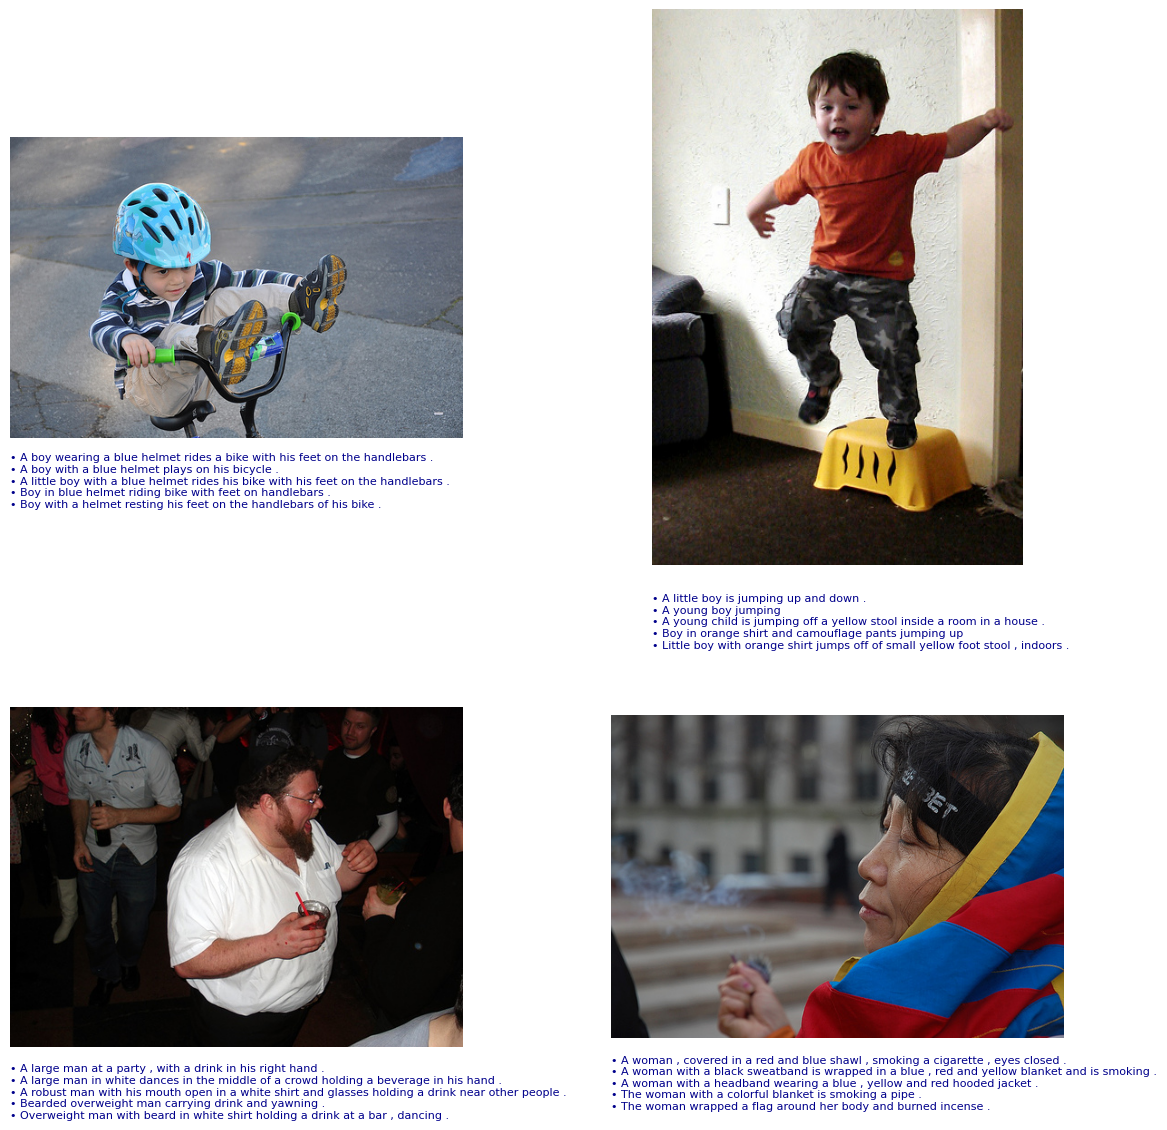

In [6]:
# ====================================================
# Utility: Display Random Images with Ground-Truth Captions
# ====================================================
# Purpose:
#   • Randomly sample N images from the dataset.
#   • Show each image in a grid with all its reference captions.
#   • Captions are neatly aligned and wrapped under each image.
# Use case:
#   • Quick qualitative inspection of dataset.
#   • Ensure preprocessing didn't break caption–image alignment.
# ====================================================

import os, random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_images(df, img_dir, n=6):
    """
    Display a random selection of images with their reference captions.

    Args:
        df (pd.DataFrame): DataFrame with columns ["image", "caption"].
        img_dir (str): Path to the folder containing the images.
        n (int): Number of unique images to sample and display.
    """
    # Randomly sample unique image filenames
    sample_images = random.sample(list(df["image"].unique()), n)

    # Build subplot grid: n//2 rows, 2 columns
    fig, axes = plt.subplots(nrows=n//2, ncols=2, figsize=(12, n*3))
    axes = axes.flatten()

    for ax, img_name in zip(axes, sample_images):
        # --- Load and show image ---
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")  # remove ticks and spines

        # --- Collect all captions for this image ---
        caps = df[df["image"] == img_name]["caption"].tolist()
        cap_text = "\n".join([f"• {c}" for c in caps])  # bullet points

        # --- Place captions just below the image ---
        ax.text(
            0, -0.05, cap_text,
            fontsize=8, color="darkblue",
            ha="left", va="top",               # left-align text under image
            transform=ax.transAxes, wrap=True  # relative to axes coords
        )

    # Adjust layout to prevent overlapping captions
    plt.tight_layout()
    plt.show()


# Example usage:
# Show 4 random images from dataset with their reference captions
show_random_images(df, IMG_DIR, n=4)


# Step 3 : Train / Validation / Test Split

In [7]:
# ====================================================
# 📊 STEP 3: Train / Validation / Test Split
# ====================================================
# Objective:
#   Partition the dataset into three disjoint subsets:
#     • Train (70%) → Used for model learning
#     • Validation (15%) → Used for hyperparameter tuning & early stopping
#     • Test (15%) → Used for final unbiased evaluation
#
# Important Notes:
#   • Splitting is performed at the IMAGE level, not the caption level.
#     This avoids data leakage (ensuring the same image does not appear 
#     in multiple splits with different captions).
#   • A fixed random seed is used to ensure reproducibility.
# ====================================================

from sklearn.model_selection import train_test_split
import pandas as pd  # ensure pandas is imported

# ----------------------------------------------------
# 1. Identify unique image filenames from the dataset
# ----------------------------------------------------
unique_images = df["image"].unique()

# Randomly sample 5000 unique images for training/evaluation.
# Using a fixed random_state ensures reproducibility of the experiment.
sampled_images = pd.Series(unique_images).sample(n=8091, random_state=42)

# ----------------------------------------------------
# 2. Subset the dataframe to include only the sampled images
# ----------------------------------------------------
df_subset = df[df["image"].isin(sampled_images)]

print("Subset pairs:", len(df_subset))                        # total image-caption pairs
print("Subset unique images:", df_subset["image"].nunique())  # number of unique images

# ----------------------------------------------------
# 3. Train / Validation / Test split (at image level)
# ----------------------------------------------------
# First, split into:
#   • Train (70%)
#   • Temp (30%) → will later be split into validation & test
train_imgs, temp_imgs = train_test_split(
    sampled_images, test_size=0.30, random_state=42
)

# Split the temp set into validation (15%) and test (15%) equally
val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.50, random_state=42
)

# ----------------------------------------------------
# 4. Assign image splits back to the dataframe
# ----------------------------------------------------
train_df = df_subset[df_subset["image"].isin(train_imgs)]
val_df   = df_subset[df_subset["image"].isin(val_imgs)]
test_df  = df_subset[df_subset["image"].isin(test_imgs)]

# ----------------------------------------------------
# 5. Print dataset sizes for verification
# ----------------------------------------------------
print(f"Train: {len(train_df)} captions from {train_df['image'].nunique()} images")
print(f"Val:   {len(val_df)} captions from {val_df['image'].nunique()} images")
print(f"Test:  {len(test_df)} captions from {test_df['image'].nunique()} images")

Subset pairs: 40455
Subset unique images: 8091
Train: 28315 captions from 5663 images
Val:   6070 captions from 1214 images
Test:  6070 captions from 1214 images


#  Step 4 : Load BLIP Model & Processor
We’ll load BLIP (Salesforce) from Hugging Face and place it on GPU if available.

In [8]:
# ====================================================
# 📌 STEP 4: Load BLIP Model & Processor
# ====================================================
# Model: Salesforce/blip-image-captioning-base
#   • Vision Transformer (ViT) → Image encoder
#   • Transformer decoder      → Caption generator
#
# Processor:
#   • Handles BOTH image preprocessing (resizing, normalization)
#     and text tokenization (encoding captions into tokens).
#
# Notes:
#   • We explicitly configure padding and EOS tokens to ensure
#     stable training and generation.
#   • Padding is set to "left" to match decoder-only models
#     and avoid warning messages.
# ====================================================

from transformers import BlipProcessor, BlipForConditionalGeneration
import torch  # ensure torch is imported

# ----------------------------------------------------
# 1. Load BLIP model & processor
# ----------------------------------------------------
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# ----------------------------------------------------
# 2. Move model to GPU (if available)
# ----------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"✅ BLIP model loaded on: {device}")

# ----------------------------------------------------
# 3. Configure tokenizer
# ----------------------------------------------------
# Extract tokenizer from processor
tokenizer = processor.tokenizer

# Ensure pad token exists; fallback to EOS if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
print("✅ Tokenizer ready. pad_token_id:", tokenizer.pad_token_id)

# ----------------------------------------------------
# 4. Adjust generation configuration
# ----------------------------------------------------
# - Left padding ensures decoder-only models work properly
# - Set pad_token_id and eos_token_id for generation
tokenizer.padding_side = "left"
model.generation_config.pad_token_id = tokenizer.pad_token_id

if tokenizer.eos_token_id is not None:
    model.generation_config.eos_token_id = tokenizer.eos_token_id

print("✅ Tokenizer & generation config ready.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✅ BLIP model loaded on: cuda
✅ Tokenizer ready. pad_token_id: 0
✅ Tokenizer & generation config ready.


#  Step 5 : Dataset Preprocessing

In [9]:
# ====================================================
# STEP 5 (optimized) — Efficient preprocessing fully in RAM
# ====================================================
# Features:
#   • Opens images safely with PIL
#   • Resizes deterministically to 224×224 (BLIP default)
#   • Processes dataset in small chunks (avoid RAM spikes)
#   • Uses tqdm for clean progress bars per split
#   • Collects all chunks directly into memory (no save_to_disk)
#   • Returns final DatasetDict in PyTorch format
# ====================================================

import os, gc
from typing import List
from PIL import Image
from datasets import Dataset, DatasetDict, concatenate_datasets
from tqdm.auto import tqdm  # progress bar

# ---- Paths
IMAGES_DIR = "/kaggle/input/flickr8k/Images"

# ---- BLIP processor resize setup
processor.image_processor.size = {"height": 224, "width": 224}
if hasattr(processor.image_processor, "do_center_crop"):
    processor.image_processor.do_center_crop = True
if hasattr(processor.image_processor, "crop_size"):
    processor.image_processor.crop_size = {"height": 224, "width": 224}

# ----------------------------------------------------
# Preprocessing function (per batch of examples)
# ----------------------------------------------------
def preprocess_function_batch(examples):
    """
    Convert image paths + captions into model-ready tensors.
    - Loads images with PIL (RGB format)
    - Applies BLIP processor for:
        • Image preprocessing (resize, normalize, tensor conversion)
        • Text tokenization (padding, truncation)
    """
    pil_images: List[Image.Image] = []
    for img_name in examples["image"]:
        img_path = os.path.join(IMAGES_DIR, img_name)
        with Image.open(img_path) as im:
            pil_images.append(im.convert("RGB"))

    enc = processor(
        images=pil_images,
        text=examples["caption"],
        padding="max_length",
        truncation=True,
        max_length=50,
    )
    return {k: v for k, v in enc.items()}

# ----------------------------------------------------
# Chunk-wise dataset processing with tqdm progress bar
# ----------------------------------------------------
def process_dataset(df, split_name: str, chunk_size: int = 1000, num_proc: int = 1):
    """
    Process a dataframe into a HuggingFace Dataset.
    
    Args:
        df (pd.DataFrame): ['image', 'caption']
        split_name (str): 'train' | 'val' | 'test'
        chunk_size (int): number of samples per chunk
        num_proc (int): parallelism for .map()

    Returns:
        HuggingFace Dataset (torch format)
    """
    n = len(df)
    num_chunks = (n + chunk_size - 1) // chunk_size
    datasets = []

    # tqdm for visual progress (per chunk)
    with tqdm(total=num_chunks, desc=f"{split_name}", unit="chunk") as pbar:
        for i in range(num_chunks):
            start, end = i * chunk_size, min((i + 1) * chunk_size, n)
            if start >= end:
                continue

            # Slice a chunk of the dataframe
            chunk_df = df.iloc[start:end].reset_index(drop=True)

            # Convert pandas → HF Dataset and apply preprocessing
            ds = Dataset.from_pandas(chunk_df)
            ds = ds.map(
                preprocess_function_batch,
                batched=True,
                batch_size=16,
                remove_columns=["image", "caption"],
                load_from_cache_file=False,
                keep_in_memory=True,
                num_proc=num_proc,
            )
            datasets.append(ds)

            # Free RAM
            del ds, chunk_df
            gc.collect()

            # Update progress bar
            pbar.update(1)

    # Concatenate all chunks into one Dataset
    ds_full = concatenate_datasets(datasets) if len(datasets) > 1 else datasets[0]

    # Set to PyTorch tensor format
    ds_full.set_format(type="torch", columns=["pixel_values", "input_ids", "attention_mask"])
    return ds_full

# ----------------------------------------------------
# Process splits with tqdm progress bar
# ----------------------------------------------------
print("\n▶️ Processing TRAIN …")
train_dataset = process_dataset(train_df, "train", chunk_size=1000)

print("\n▶️ Processing VAL …")
val_dataset   = process_dataset(val_df, "val", chunk_size=1000)

print("\n▶️ Processing TEST …")
test_dataset  = process_dataset(test_df, "test", chunk_size=1000)

# ----------------------------------------------------
# Final DatasetDict assembly
# ----------------------------------------------------
dataset = DatasetDict({
    "train": train_dataset,
    "val":   val_dataset,
    "test":  test_dataset
})

# ----------------------------------------------------
# Compact summary of splits
# ----------------------------------------------------
def _brief(ds, name):
    print(f"✅ {name:5s} → rows={len(ds):5d} | features={list(ds.features.keys())}")

_brief(train_dataset, "train")
_brief(val_dataset,   "val")
_brief(test_dataset,  "test")

print("\n Preprocessing complete (in memory). Ready for Step 6.")



▶️ Processing TRAIN …


train:   0%|          | 0/29 [00:00<?, ?chunk/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]


▶️ Processing VAL …


val:   0%|          | 0/7 [00:00<?, ?chunk/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]


▶️ Processing TEST …


test:   0%|          | 0/7 [00:00<?, ?chunk/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

✅ train → rows=28315 | features=['pixel_values', 'input_ids', 'attention_mask']
✅ val   → rows= 6070 | features=['pixel_values', 'input_ids', 'attention_mask']
✅ test  → rows= 6070 | features=['pixel_values', 'input_ids', 'attention_mask']

 Preprocessing complete (in memory). Ready for Step 6.


# STEP 6 : Collator + Reusable Metrics (for post-training eval) (Single and Multi reference test)

In [10]:
!pip install -q rouge-score nltk
# Optional (for CIDEr). If it fails, our code already skips CIDEr gracefully.
!pip install -q pycocoevalcap

import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.4 MB/s eta 0:00:0000:0100:01


True

In [11]:
# ====================================================
# STEP 6 — Collator + Reusable Metrics (for post-training eval)
# ====================================================
# Design choices:
#   • No compute_metrics passed to Trainer → faster epochs (val = loss only).
#   • Define compute_metrics_from_ids() for post-training evaluation on test data.
#   • Train collator includes stronger augmentations (default: disabled).
#   • Eval collator stays clean (no augmentations).
# ====================================================

import os, re, random, numpy as np, torch
from typing import List, Dict, Any

# ----------------------------------------------------
# Reproducibility utilities
# ----------------------------------------------------
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Silence HuggingFace tokenizer parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Ensure padding tokens are configured correctly
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if getattr(model.config, "pad_token_id", None) is None:
    model.config.pad_token_id = tokenizer.pad_token_id

# ----------------------------------------------------
# Data Collator (with optional augmentation)
# ----------------------------------------------------
try:
    import torchvision.transforms as T
except Exception:
    T = None  # torchvision may be missing in some environments

class CaptionCollator:
    """
    Custom collator for image-caption pairs.
    - Prepares batch tensors for model input.
    - Optionally applies augmentations (flip, crop, jitter, rotation).
    """

    def __init__(self, tok, proc, augment: bool = False):
        self.tok, self.proc, self.augment = tok, proc, augment

        # Stronger augmentations (only if torchvision is available)
        if T is not None:
            self.augment_tfms = T.Compose([
                T.RandomResizedCrop(224, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2,
                              saturation=0.1, hue=0.05),
                T.RandomRotation(degrees=10),
                T.RandomGrayscale(p=0.1),
            ])

        # Normalization stats from BLIP processor
        mean = torch.tensor(proc.image_processor.image_mean).view(3, 1, 1)
        std  = torch.tensor(proc.image_processor.image_std).view(3, 1, 1)
        self.mean, self.std = mean, std

    def _denorm(self, x):
        return (x * self.std + self.mean).clamp(0, 1)

    def _renorm(self, x):
        return (x - self.mean) / self.std

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        pvs, ids, msk = [], [], []

        for f in features:
            pv  = torch.as_tensor(f["pixel_values"],  dtype=torch.float32)
            iid = torch.as_tensor(f["input_ids"],     dtype=torch.long)
            am  = torch.as_tensor(f["attention_mask"], dtype=torch.long)

            if self.augment and T is not None:
                x = self._denorm(pv)
                x = self.augment_tfms(x)
                pv = self._renorm(x)

            pvs.append(pv); ids.append(iid); msk.append(am)

        pvs  = torch.stack(pvs, 0)
        ids  = torch.nn.utils.rnn.pad_sequence(ids, batch_first=True,
                                               padding_value=self.tok.pad_token_id)
        msk  = torch.nn.utils.rnn.pad_sequence(msk, batch_first=True,
                                               padding_value=0)

        labels = ids.clone()
        labels[msk == 0] = -100

        return {"pixel_values": pvs,
                "input_ids": ids,
                "attention_mask": msk,
                "labels": labels}

# Instantiate collators
train_collator = CaptionCollator(tokenizer, processor, augment=False)
eval_collator  = CaptionCollator(tokenizer, processor, augment=False)

# ----------------------------------------------------
# Reusable Evaluation Metrics
# ----------------------------------------------------
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
_smooth = SmoothingFunction().method3
_punct_re = re.compile(r"[^\w\s]")

def _normalize(s: str) -> str:
    s = s.lower()
    s = _punct_re.sub(" ", s)
    return " ".join(s.split())

# Prefer rouge-score (fast); fallback to evaluate
try:
    from rouge_score import rouge_scorer
    _rs = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    _use_rouge_score = True
except Exception:
    import evaluate
    _rouge_eval = evaluate.load("rouge")
    _use_rouge_score = False

def _ensure_2d_ids(x, pad_id):
    if isinstance(x, tuple): x = x[0]
    arr = np.array(x, dtype=object)
    if arr.ndim == 1:
        arr = np.expand_dims(arr, 0)
    return [[int(v) for v in row] for row in arr]

def compute_metrics_from_ids(pred_ids, label_ids, tokenizer, multi_refs=None):
    """
    Compute BLEU, ROUGE-L, METEOR with single- or multi-reference support.
    """
    # Replace ignore index (-100) with pad
    pred_ids  = np.where(pred_ids  != -100, pred_ids,  tokenizer.pad_token_id)
    label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)

    preds2 = _ensure_2d_ids(pred_ids,  tokenizer.pad_token_id)
    labs2  = _ensure_2d_ids(label_ids, tokenizer.pad_token_id)

    pred_texts = tokenizer.batch_decode(preds2, skip_special_tokens=True)
    ref_texts  = tokenizer.batch_decode(labs2,  skip_special_tokens=True)

    preds_norm = [_normalize(t) for t in pred_texts]

    hyps_tok = [p.split() for p in preds_norm]

    if multi_refs is None:
        # single-reference (default)
        refs_norm = [_normalize(t) for t in ref_texts]
        refs_tok  = [[r.split()] for r in refs_norm]
    else:
        # multi-reference (use dict: idx → [refs])
        refs_tok, refs_norm = [], []
        for i, ref_single in enumerate(ref_texts):
            ref_list = multi_refs.get(i, [ref_single])
            refs_norm.append([_normalize(r) for r in ref_list])
            refs_tok.append([r.split() for r in refs_norm[-1]])

    # ---- BLEU ----
    bleu1 = corpus_bleu(refs_tok, hyps_tok, weights=(1.0, 0, 0, 0), smoothing_function=_smooth)
    bleu2 = corpus_bleu(refs_tok, hyps_tok, weights=(0.5, 0.5, 0, 0), smoothing_function=_smooth)
    bleu3 = corpus_bleu(refs_tok, hyps_tok, weights=(1/3, 1/3, 1/3, 0), smoothing_function=_smooth)
    bleu4 = corpus_bleu(refs_tok, hyps_tok, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=_smooth)

    # ---- METEOR ----
    if multi_refs is None:
        meteor_vals = [meteor_score([ref[0]], hyp) for ref, hyp in zip(refs_tok, hyps_tok)]
    else:
        meteor_vals = [max(meteor_score(refs, hyp) for refs in [refset])
                       for refset, hyp in zip(refs_tok, hyps_tok)]
    meteor_mean = float(np.mean(meteor_vals)) if meteor_vals else 0.0

    # ---- ROUGE-L ----
    if _use_rouge_score:
        if multi_refs is None:
            rl_vals = [_rs.score(ref, hyp)["rougeL"].fmeasure for ref, hyp in zip(ref_texts, preds_norm)]
        else:
            rl_vals = [max(_rs.score(ref, hyp)["rougeL"].fmeasure for ref in refset)
                       for refset, hyp in zip(refs_norm, preds_norm)]
        rougeL = float(np.mean(rl_vals)) if rl_vals else 0.0
    else:
        if multi_refs is None:
            rougeL = float(_rouge_eval.compute(predictions=preds_norm, references=ref_texts)["rougeL"])
        else:
            rouge_vals = []
            for refset, hyp in zip(refs_norm, preds_norm):
                scores = [_rouge_eval.compute(predictions=[hyp], references=[r])["rougeL"] for r in refset]
                rouge_vals.append(max(scores))
            rougeL = float(np.mean(rouge_vals)) if rouge_vals else 0.0

    return {"bleu1": float(bleu1), "bleu2": float(bleu2),
            "bleu3": float(bleu3), "bleu4": float(bleu4),
            "rougeL": rougeL, "meteor": meteor_mean}

# ----------------------------------------------------
# Bridge for HuggingFace Trainer
# ----------------------------------------------------
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    mr = multi_refs if "multi_refs" in globals() else None
    return compute_metrics_from_ids(preds, labels, tokenizer, multi_refs=mr)

print("✅ Step 6 ready: collators built; metrics helper now supports multi-ref.")


✅ Step 6 ready: collators built; metrics helper now supports multi-ref.


# Step 7 : Define Trainer with loss-only validation + regularization

In [12]:
# ====================================================
# STEP 7 (Consolidated): Trainer with loss-only validation + regularization
# ====================================================
# Key Features:
#   • Loss-only validation (no generation → faster training)
#   • No intermediate checkpoints (disk-safe; best weights kept in RAM)
#   • Early stopping callback (patience-based)
#   • Regularization: dropout, label smoothing, cosine LR, warmup, weight decay
#   • ViT encoder frozen for first 2–3 epochs, then unfrozen
#   • Train-time augmentation enabled (now uses stronger Step 6 pipeline)
# ====================================================

import os, copy, torch, torch.nn as nn
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainerCallback

# ----------------------------------------------------
# Environment setup
# ----------------------------------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Output directory (safe for Kaggle /temp storage)
output_dir = "/kaggle/working/blip_caption_model"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------------------------------
# Custom Trainer (loss-only eval, no generation)
# ----------------------------------------------------
class LossOnlyTrainer(Seq2SeqTrainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Override: always compute loss-only for eval (skip generation)."""
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss.detach() if hasattr(outputs, "loss") else None
        return (loss, None, inputs.get("labels"))

# ----------------------------------------------------
# Training arguments
# ----------------------------------------------------
args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    do_train=True, do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,      # effective batch = 16
    num_train_epochs=8,                 # early stopping may cut earlier
    learning_rate=5e-5,
    weight_decay=0.05,                  # slightly stronger WD to reduce overfitting
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    remove_unused_columns=False,        # keep pixel_values in batch
    predict_with_generate=False,        # loss-only validation
    eval_strategy="epoch",              # eval once per epoch
    save_strategy="no",                 # no mid-saves to disk
    save_total_limit=0,
    load_best_model_at_end=False,       # best weights restored manually (RAM)
    report_to="none",                   # silence disk logging
    logging_strategy="steps",
    logging_steps=50,
    fp16=True,
    dataloader_num_workers=2,
)

# ----------------------------------------------------
# Instantiate trainer (no metrics; collator swapped later)
# ----------------------------------------------------
trainer = LossOnlyTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=eval_collator,  # eval collator (clean, no aug)
    compute_metrics=None,
)

# ----------------------------------------------------
# Regularization: Dropout on decoder
# ----------------------------------------------------
def set_dropout(module, p=0.4):
    """Recursively set dropout probability in a module."""
    n = 0
    for m in module.modules():
        if isinstance(m, nn.Dropout):
            m.p = p; n += 1
    return n

base_model = trainer.model.module if hasattr(trainer.model, "module") else trainer.model
dec = getattr(base_model, "text_decoder", None) or getattr(base_model, "language_model", None)

if dec is not None:
    n = set_dropout(dec, p=0.4)
    if hasattr(dec, "config"):
        for a in ("hidden_dropout_prob", "attention_probs_dropout_prob"):
            if hasattr(dec.config, a):
                setattr(dec.config, a, 0.4)
    print(f"Dropout p=0.4 on {n} decoder layers")
else:
    n = set_dropout(base_model, p=0.4)
    print(f"Dropout p=0.4 on {n} layers (global)")

# ----------------------------------------------------
# Regularization: Label smoothing
# ----------------------------------------------------
try:
    trainer.args.label_smoothing_factor = 0.1
    print("Label smoothing = 0.1")
except Exception as e:
    print("label_smoothing not available:", e)

# ----------------------------------------------------
# Optimizer: Proper AdamW with no decay on LayerNorm/bias
# ----------------------------------------------------
from torch.optim import AdamW

def make_wd_optimizer(model, lr=5e-5, wd=0.05):
    """AdamW with weight decay, excluding bias/LayerNorm parameters."""
    m = model.module if hasattr(model, "module") else model
    decay, nodecay = [], []
    for n, p in m.named_parameters():
        if not p.requires_grad:
            continue
        name = n.lower()
        if any(k in name for k in ["bias", "layernorm.weight", "ln_", "norm.weight"]):
            nodecay.append(p)
        else:
            decay.append(p)
    return AdamW(
        [{"params": decay, "weight_decay": wd},
         {"params": nodecay, "weight_decay": 0.0}],
        lr=lr,
    )

trainer.optimizer = make_wd_optimizer(trainer.model, lr=3e-5, wd=0.05)
print("AdamW set (wd=0.05; no decay on bias/LayerNorm)")

# ----------------------------------------------------
# Freeze ViT for first 2–3 epochs → then unfreeze
# ----------------------------------------------------
vit = getattr(base_model, "vision_model", None)
if vit is not None:
    for p in vit.parameters():
        p.requires_grad = False
    print("Vision encoder frozen for epochs 1–3")

    class UnfreezeAfter3Epochs(TrainerCallback):
        def __init__(self): self.done = False
        def on_epoch_end(self, args, state, control, **kw):
            if not self.done and (state.epoch or 0) >= 3:
                m = trainer.model.module if hasattr(trainer.model, "module") else trainer.model
                for p in m.vision_model.parameters():
                    p.requires_grad = True
                self.done = True
                print("Vision encoder unfrozen")
            return control

    trainer.add_callback(UnfreezeAfter3Epochs())

# ----------------------------------------------------
# Train-time augmentation (enabled only during training)
# ----------------------------------------------------
class AugBlipTrainer(type(trainer)):
    def get_train_dataloader(self):
        # Use strong Step 6 augmentation here
        self.data_collator = CaptionCollator(tokenizer, processor, augment=True)
        return super().get_train_dataloader()
    def get_eval_dataloader(self, eval_dataset=None):
        # Keep eval collator clean
        self.data_collator = eval_collator
        return super().get_eval_dataloader(eval_dataset)

trainer.__class__ = AugBlipTrainer
print("Train-time augmentation enabled (stronger Step 6 pipeline)")

# ----------------------------------------------------
# Early stopping + Best weights kept in RAM
# ----------------------------------------------------
class BestInRAMCallback(TrainerCallback):
    """
    Early stopping with in-RAM best model checkpointing.
    - Stops training if patience exceeded.
    - Keeps best model weights in memory (no disk writes).
    """
    def __init__(self, metric_name="eval_loss", greater_is_better=False, patience=1, delta=1e-3):
        self.metric_name = metric_name
        self.greater_is_better = greater_is_better
        self.patience = patience
        self.delta = delta
        self.best = None
        self.bad_epochs = 0
        self.best_state = None

    def on_evaluate(self, args, state, control, metrics=None, model=None, **kwargs):
        if not metrics or self.metric_name not in metrics:
            return control
        val = float(metrics[self.metric_name])
        is_better = (
            (val > (self.best + self.delta)) if (self.best is not None and self.greater_is_better)
            else (val < (self.best - self.delta)) if (self.best is not None)
            else True
        )
        if is_better:
            self.best = val
            self.bad_epochs = 0
            m = model.module if hasattr(model, "module") else model
            self.best_state = copy.deepcopy(m.state_dict())
            print(f"(RAM) New best {self.metric_name}: {val:.6f}")
        else:
            self.bad_epochs += 1
            if self.bad_epochs > self.patience:
                control.should_training_stop = True
        return control

    def on_train_end(self, args, state, control, model=None, **kwargs):
        if self.best_state is not None:
            m = model.module if hasattr(model, "module") else model
            m.load_state_dict(self.best_state)
            print("Loaded best weights from RAM into model")
        return control

# ----------------------------------------------------
# Pretty printer for losses
# ----------------------------------------------------
class PrettyLossCallback(TrainerCallback):
    """Prints epoch-wise train/val losses in a clean tabular format."""
    def __init__(self):
        self.last_train_loss = None
        self.header = False

    def on_log(self, args, state, control, logs=None, **kw):
        if logs and "loss" in logs:
            self.last_train_loss = logs["loss"]

    def on_evaluate(self, args, state, control, metrics=None, **kw):
        if not metrics:
            return
        if not self.header:
            print("\nEpoch\tTrainLoss\tValLoss")
            self.header = True
        tl = self.last_train_loss if self.last_train_loss is not None else float("nan")
        print(f"{int(round(state.epoch or 0))}\t{tl:.6f}\t{metrics.get('eval_loss', float('nan')):.6f}")

# ----------------------------------------------------
# Callback management
# ----------------------------------------------------
# Remove TensorBoard callback (avoid writing to disk)
try:
    from transformers.integrations import TensorBoardCallback
    trainer.remove_callback(TensorBoardCallback)
except Exception:
    pass

# Add callbacks: Early stopping + pretty printer
trainer.add_callback(BestInRAMCallback(metric_name="eval_loss", greater_is_better=False, patience=1, delta=1e-3))
trainer.add_callback(PrettyLossCallback())

print("Trainer configured (loss-only validation, strong Step 6 augmentation, "
      "longer ViT freeze, stricter early stopping, stronger weight decay).")


Dropout p=0.4 on 61 decoder layers
Label smoothing = 0.1
AdamW set (wd=0.05; no decay on bias/LayerNorm)
Vision encoder frozen for epochs 1–3
Train-time augmentation enabled (stronger Step 6 pipeline)
Trainer configured (loss-only validation, strong Step 6 augmentation, longer ViT freeze, stricter early stopping, stronger weight decay).


# STEP 8 : Train and save the model

In [13]:
# ====================================================
# STEP 8 — Training (loss-only) → EarlyStopping → Cleanup → Final Save
# ====================================================
# Workflow:
#   1. Configure EarlyStopping (must be set BEFORE trainer.train).
#   2. Train with loss-only validation (fast; no caption generation).
#   3. Early stopping halts training once val loss stops improving.
#   4. Cleanup memory/disk (delete temp datasets & shards).
#   5. Save final model + tokenizer exactly once (safe for Kaggle).
# ====================================================

import os, gc, torch
from transformers import EarlyStoppingCallback

# ----------------------------------------------------
# Utility: Safely set Trainer args with logging
# ----------------------------------------------------
def _set(name, value):
    """Safely set a Trainer argument and log the update."""
    try:
        setattr(trainer.args, name, value)
        print(f"{name} = {value}")
    except Exception as e:
        print(f"⚠️ Could not set {name}: {e}")

# ----------------------------------------------------
# Trainer configuration (loss-only validation)
# ----------------------------------------------------
trainer.compute_metrics = None                # disable metrics (loss-only eval)
_set("predict_with_generate", False)          # skip generate() calls during eval
_set("metric_for_best_model", "eval_loss")    # ES monitors validation loss
_set("greater_is_better", False)

# Ensure validation is run (needed for ES)
_set("evaluation_strategy", "epoch")
_set("eval_strategy", "epoch")

# Disable checkpoint saving (keep disk clean)
_set("save_strategy", "no")
_set("save_total_limit", 0)
_set("load_best_model_at_end", False)
_set("report_to", "none")

# Beam search params (not used here, but set explicitly)
_set("generation_num_beams", 5)

# Ensure we have a validation dataset for ES
assert trainer.eval_dataset is not None, "Validation dataset is missing."

# ----------------------------------------------------
# EarlyStopping configuration
# ----------------------------------------------------
# Remove any existing EarlyStoppingCallback before adding a fresh one
for cb in list(trainer.callback_handler.callbacks):
    if isinstance(cb, EarlyStoppingCallback):
        trainer.remove_callback(EarlyStoppingCallback)

# Add EarlyStopping (patience=1 epoch, min_delta=5e-4)
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=5e-4,
))
print("EarlyStopping configured on eval_loss (loss-only validation).")

# ----------------------------------------------------
# Train
# ----------------------------------------------------
print("🚀 Training (loss-only, no mid-saves) with early stopping…")
trainer.args.num_train_epochs = 5  # ES will stop earlier if convergence is reached
train_result = trainer.train()

# # ----------------------------------------------------
# # Cleanup: Free memory and temporary shards
# # ----------------------------------------------------
# print("\n🧹 Freeing datasets from memory…")
# del train_dataset, val_dataset
# gc.collect()

# print("🗑️ Removing preprocessed shards to free disk…")
# !rm -rf /kaggle/working/train_part* /kaggle/working/val_part* /kaggle/working/test_part* \
#         /kaggle/working/blip_caption_model/checkpoint* \
#         /kaggle/working/blip_caption_model/runs \
#         /kaggle/working/blip_caption_model/logs
# !df -h /kaggle/working

# ----------------------------------------------------
# Save final model (once only)
# ----------------------------------------------------
final_dir = "/kaggle/working/blip_caption_model/final"
os.makedirs(final_dir, exist_ok=True)

try:
    trainer.args.save_safetensors = True  # safer serialization if supported
except Exception:
    pass

print("\n💾 Saving final model once…")
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print("Saved final weights to:", final_dir)


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


predict_with_generate = False
metric_for_best_model = eval_loss
greater_is_better = False
evaluation_strategy = epoch
eval_strategy = epoch
save_strategy = no
save_total_limit = 0
load_best_model_at_end = False
report_to = none
generation_num_beams = 5
EarlyStopping configured on eval_loss (loss-only validation).
🚀 Training (loss-only, no mid-saves) with early stopping…


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss
1,2.330200,2.001294
2,2.096700,1.883061
3,1.974800,1.846445
4,1.764900,1.732254
5,1.669800,1.723804


(RAM) New best eval_loss: 2.001294

Epoch	TrainLoss	ValLoss
1	2.330200	2.001294
(RAM) New best eval_loss: 1.883061
2	2.096700	1.883061
Vision encoder unfrozen
(RAM) New best eval_loss: 1.846445
3	1.974800	1.846445
(RAM) New best eval_loss: 1.723804
5	1.669800	1.723804
Loaded best weights from RAM into model

💾 Saving final model once…
Saved final weights to: /kaggle/working/blip_caption_model/final


# Step 9 : Plot Train vs Val Loss (per epoch) and export CSV 

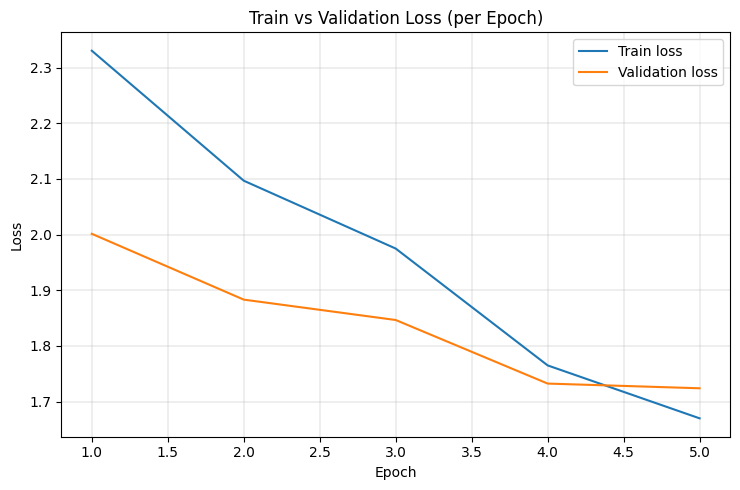

In [14]:
# ====================================================
# STEP 9 — Plot Training vs Validation Loss (per epoch)
# ====================================================
# Workflow:
#   1. Extract loss values (train + validation) from Trainer log history.
#   2. Align records by epoch (validation closes each epoch).
#   3. Build a tidy DataFrame for inspection & export.
#   4. Plot loss curves with matplotlib for visual comparison.
#   5. Save both plot (.png) and data (.csv) for reproducibility.
#   6. Consistent with Step 8: loss-only validation, early stopping.
# ====================================================

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Extract loss history from Trainer
# ----------------------------------------------------
hist = trainer.state.log_history

train_loss_per_epoch = {}
val_loss_per_epoch   = {}

last_step_loss = None
current_epoch  = None

for rec in hist:
    # Capture training step-level loss
    if "loss" in rec and "epoch" in rec:
        current_epoch  = int(round(float(rec["epoch"])))
        last_step_loss = float(rec["loss"])

    # Capture validation loss (logged once per epoch)
    if "eval_loss" in rec and "epoch" in rec:
        e = int(round(float(rec["epoch"])))
        if e >= 1:
            val_loss_per_epoch[e] = float(rec["eval_loss"])
            # Attach the last seen training loss for that epoch
            if last_step_loss is not None:
                train_loss_per_epoch[e] = last_step_loss

# ----------------------------------------------------
# Build tidy DataFrame (epoch ≥ 1)
# ----------------------------------------------------
epochs = sorted(set(train_loss_per_epoch) | set(val_loss_per_epoch))
df = pd.DataFrame({
    "epoch":      epochs,
    "train_loss": [train_loss_per_epoch.get(e, np.nan) for e in epochs],
    "val_loss":   [val_loss_per_epoch.get(e,   np.nan) for e in epochs],
})

# ----------------------------------------------------
# Plot loss curves (Train vs Validation)
# ----------------------------------------------------
plt.figure(figsize=(7.5, 5))
plt.plot(df["epoch"], df["train_loss"],  label="Train loss")
plt.plot(df["epoch"], df["val_loss"],    label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (per Epoch)")
plt.grid(True, linewidth=0.3)
plt.legend()
plt.tight_layout()

# Save plot to disk
plot_path = "/kaggle/working/train_vs_val_loss.png"
plt.savefig(plot_path, dpi=300)
plt.show()


# STEP 10 : Final Model Evaluation (Single + Multi-reference)

In [15]:
# ====================================================
# BUILD MULTI-REFS FOR TEST (index-aligned with HF test_dataset)
# ====================================================
import os, pandas as pd

# Locate captions.txt
cap_path = None
for root, _, files in os.walk("/kaggle/input"):
    for f in files:
        if "caption" in f.lower():
            cap_path = os.path.join(root, f)
            break
assert cap_path, "❌ captions.txt not found"
print("Using captions file:", cap_path)

# Load captions
df_caps = pd.read_csv(cap_path)
df_caps.columns = [c.strip().lower() for c in df_caps.columns]
if "image" not in df_caps.columns:
    if "filename" in df_caps.columns:
        df_caps.rename(columns={"filename": "image"}, inplace=True)
    else:
        df_caps.columns = ["image", "caption"]

# Group into image → [cap1..cap5]
refs_map = df_caps.groupby("image")["caption"].apply(list).to_dict()

# Use test_df (raw dataframe split before preprocessing) to align indices
multi_refs_test = {}
for i, row in enumerate(test_df.itertuples(index=False)):
    img_name = row.image
    if img_name in refs_map:
        multi_refs_test[i] = refs_map[img_name]

print(f"Loaded {len(refs_map)} unique images with references.")
print(f"Built multi_refs_test with {len(multi_refs_test)} entries (should match len(test_dataset)={len(test_dataset)}).")


Using captions file: /kaggle/input/flickr8k/captions.txt
Loaded 8091 unique images with references.
Built multi_refs_test with 6070 entries (should match len(test_dataset)=6070).


In [16]:
# ====================================================
# STEP 10 — Final Model Evaluation (Single + Multi-ref)
# ====================================================
import os, warnings, numpy as np, pandas as pd, torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", message="To copy construct from a tensor")

assert "trainer" in globals(), "Trainer not found — run Step 8 first."
assert "test_dataset" in globals(), "TEST dataset missing — rerun Step 5 if needed."
assert "compute_metrics_from_ids" in globals(), "Metrics helper missing — rerun Step 6."

# ---------------------------
# Eval-only Trainer
# ---------------------------
class BlipEvalTrainer(Seq2SeqTrainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)

        # Teacher-forced loss (for logging only)
        loss = None
        if "labels" in inputs:
            with torch.no_grad():
                out = model(**inputs)
                loss = out.loss.detach()

        if prediction_loss_only:
            return (loss, None, None)

        gen_model = model.module if hasattr(model, "module") else model
        gen_kwargs = dict(
            max_length=35, min_length=5, num_beams=5,
            no_repeat_ngram_size=2, length_penalty=1.05, early_stopping=True
        )
        with torch.no_grad():
            pred_ids = gen_model.generate(pixel_values=inputs["pixel_values"], **gen_kwargs)

        return (loss, pred_ids, inputs.get("labels"))

# Minimal args (no logging/saving)
eval_args = Seq2SeqTrainingArguments(
    output_dir=trainer.args.output_dir,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    eval_strategy="no",
    save_strategy="no",
    report_to="none",
    fp16=True,
)

eval_trainer = BlipEvalTrainer(
    model=trainer.model,
    args=eval_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=eval_collator,
    compute_metrics=None,
)

# ---------------------------
# Run evaluation
# ---------------------------
print("Evaluating on TEST… (generating from images only) \n")
pred_output = eval_trainer.predict(test_dataset)
pred_ids   = pred_output.predictions
label_ids  = pred_output.label_ids

test_loss = float(pred_output.metrics.get("test_loss", np.nan)
                  if "test_loss" in pred_output.metrics else np.nan)

# ---------------------------
# Compute metrics
# ---------------------------
metrics_single = compute_metrics_from_ids(pred_ids, label_ids, tokenizer, multi_refs=None)
metrics_multi  = None
if "multi_refs_test" in globals():
    metrics_multi = compute_metrics_from_ids(pred_ids, label_ids, tokenizer, multi_refs=multi_refs_test)

# ---------------------------
# Build comparison DataFrame (vertical layout)
# ---------------------------
rows = []

# Single-ref metrics
rows.append(("test_loss", metrics_single.get("test_loss", test_loss)))
for key, val in metrics_single.items():
    if key != "test_loss":
        rows.append((f"{key}", val))

# Convert to dict for DF
comparison = {"Metric": [r[0] for r in rows], "Single-ref": [r[1] for r in rows]}

# Add Multi-ref if available
if metrics_multi:
    comparison["Multi-ref"] = []
    for metric, _ in rows:
        if metric == "test_loss":
            comparison["Multi-ref"].append(None)  # no loss for multi-ref
        else:
            comparison["Multi-ref"].append(metrics_multi[metric])

# Build DataFrame
comparison_df = pd.DataFrame(comparison)

# Format numbers
def _fmt(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "-"
    return f"{x:.6f}" if isinstance(x, (float, int, np.floating)) else str(x)

print("\n================= TEST METRICS COMPARISON =================")
print(comparison_df.applymap(_fmt).to_string(index=False))
print("==========================================================\n")

# ---------------------------
# Save results
# ---------------------------
comparison_df.to_csv("/kaggle/working/test_metrics_comparison_vertical.csv", index=False)
print("Saved vertical comparison to: /kaggle/working/test_metrics_comparison_vertical.csv")


Evaluating on TEST… (generating from images only) 




================= TEST METRICS COMPARISON =================
   Metric Single-ref Multi-ref
test_loss   1.744812         -
    bleu1   0.283151  0.567617
    bleu2   0.170939  0.411067
    bleu3   0.107844  0.291166
    bleu4   0.069293  0.203921
   rougeL   0.326666  0.454657
   meteor   0.338822  0.512312

Saved vertical comparison to: /kaggle/working/test_metrics_comparison_vertical.csv


# STEP 11 : Visualize Sample test dataset (image | predicted caption + ground truth).

Saved visual sanity check panel to /kaggle/working/viz_sanity_check.png


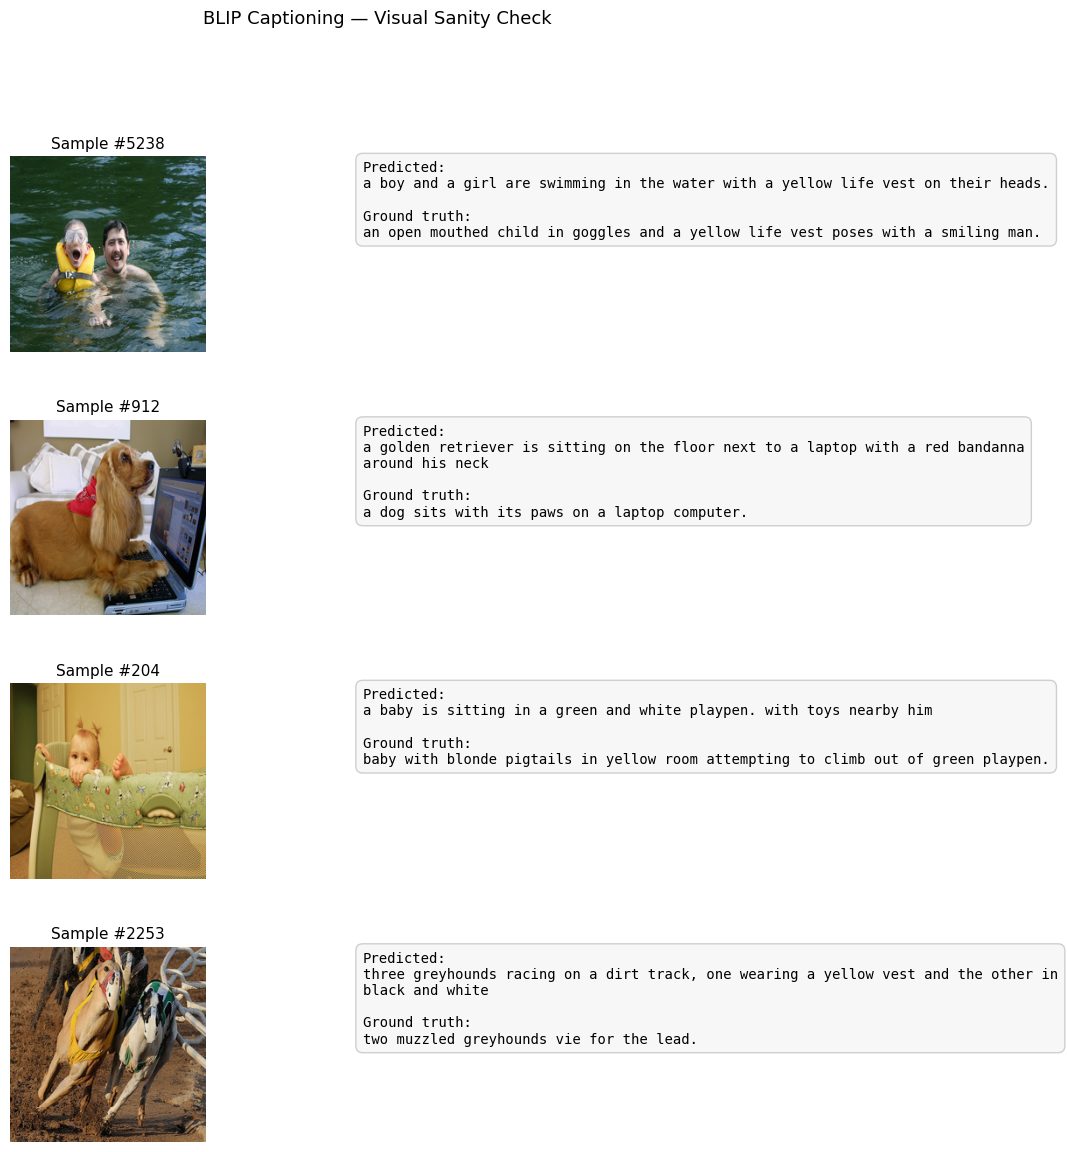

In [17]:
# ====================================================
# STEP 11 — Visual Sanity-Check Grid (+ Optional CSV)
# ====================================================
# Workflow:
#   1. Pick random samples from validation/test split.
#   2. Show grid with: (image | predicted caption + ground truth).
#   3. Provide visual inspection of caption quality.
#   4. Save the visualization panel for reproducibility.
# ====================================================

import os, math, random, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from textwrap import fill

# ----------------------------------------------------
# Select model + device
# ----------------------------------------------------
_model = trainer.model.module if hasattr(trainer.model, "module") else trainer.model
device = next(_model.parameters()).device

# ----------------------------------------------------
# Helper: Convert normalized tensor → PIL image
# ----------------------------------------------------
def unnorm_to_pil(pv):
    """
    Convert normalized pixel_values tensor back to PIL image.
    Undo normalization using BLIP processor stats.
    """
    x = torch.tensor(pv, dtype=torch.float32)
    mean = torch.tensor(processor.image_processor.image_mean).view(3, 1, 1)
    std  = torch.tensor(processor.image_processor.image_std).view(3, 1, 1)
    x = (x * std + mean).clamp(0, 1)  # de-normalize to [0,1]
    img = (x.permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")
    return Image.fromarray(img)

# ----------------------------------------------------
# Helper: Decode ground-truth caption (remove padding)
# ----------------------------------------------------
def decode_gt(input_ids, attention_mask):
    ids = [tid for tid, m in zip(input_ids, attention_mask) if m == 1]
    return tokenizer.decode(ids, skip_special_tokens=True)

# ----------------------------------------------------
# Helper: Generate caption from pixel_values
# ----------------------------------------------------
@torch.no_grad()
def predict_from_pixel_values(pv, num_beams=5, max_len=35):
    """
    Generate caption from image only (no text leakage).
    Uses the model's generate() with beam search.
    """
    _model.eval()
    pv = torch.as_tensor(pv, dtype=torch.float32).unsqueeze(0).to(device)
    out = _model.generate(
        pixel_values=pv,
        num_beams=num_beams,
        max_length=max_len,
        min_length=5,
        no_repeat_ngram_size=2,
        length_penalty=1.05,
        early_stopping=True,
    )
    return tokenizer.decode(out[0].tolist(), skip_special_tokens=True)

# ----------------------------------------------------
# Choose split to visualize (test preferred, else val)
# ----------------------------------------------------
viz_ds = test_dataset if "test_dataset" in globals() else val_dataset

# ----------------------------------------------------
# Grid configuration
# ----------------------------------------------------
K = 4                               # number of samples
K = min(K, len(viz_ds))             # safety: cap at dataset size
idxs = random.sample(range(len(viz_ds)), K)

# One sample per row, two columns (image | captions)
fig = plt.figure(figsize=(12, 3.2 * K))
gs = gridspec.GridSpec(K, 2, width_ratios=[1.0, 1.4], wspace=0.15, hspace=0.35)

for r, i in enumerate(idxs):
    ex   = viz_ds[i]
    img  = unnorm_to_pil(ex["pixel_values"])
    gt   = decode_gt(ex["input_ids"], ex["attention_mask"])
    pred = predict_from_pixel_values(ex["pixel_values"], num_beams=5, max_len=35)

    # --- Left cell: image ---
    ax_img = fig.add_subplot(gs[r, 0])
    ax_img.imshow(img); ax_img.axis("off")
    ax_img.set_title(f"Sample #{i}", fontsize=11)

    # --- Right cell: predicted vs ground-truth captions ---
    ax_txt = fig.add_subplot(gs[r, 1]); ax_txt.axis("off")
    block = (
        f"Predicted:\n{fill(pred, 85)}\n\n"
        f"Ground truth:\n{fill(gt, 85)}"
    )
    ax_txt.text(
        0.02, 0.98, block,
        transform=ax_txt.transAxes,
        va="top", ha="left", fontsize=10, family="monospace",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="#f7f7f7", edgecolor="#cfcfcf", alpha=1.0)
    )

# Global figure formatting
plt.suptitle("BLIP Captioning — Visual Sanity Check", y=0.995, fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.99])

# ----------------------------------------------------
# Save visualization panel
# ----------------------------------------------------
panel_path = "/kaggle/working/viz_sanity_check.png"
plt.savefig(panel_path, dpi=150, bbox_inches="tight")
print(f"Saved visual sanity check panel to {panel_path}")


# STEP 12 : Inference & Final Demo (Upload Images → Captions)

In [19]:
# ====================================================
# STEP 12 — Inference & Final Demo (Upload Images → Captions)
# ====================================================
# Workflow:
#   1. Load fine-tuned BLIP model + tokenizer + processor.
#   2. Provide helpers:
#       • caption_image() — single image (path / PIL / bytes).
#       • caption_many()  — batch multiple images + CSV export.
#   3. Interactive Demo (Upload 1 or many images → captions shown under each).
#   4. All results saved to CSV for later inspection.
# ====================================================

import os, io, torch, pandas as pd
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ---------------------------
# Load fine-tuned model
# ---------------------------
FINAL_DIR = "/kaggle/working/blip_caption_model/final"

inf_model = BlipForConditionalGeneration.from_pretrained(FINAL_DIR)
inf_tokenizer = AutoTokenizer.from_pretrained(FINAL_DIR)
inf_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Replace processor tokenizer with fine-tuned one
inf_processor.tokenizer = inf_tokenizer
inf_processor.image_processor.size = {"height": 224, "width": 224}

device = "cuda" if torch.cuda.is_available() else "cpu"
inf_model.to(device).eval()


# ---------------------------
# Helper: Load image safely
# ---------------------------
def _load_image(src):
    """Load an image (path / PIL / bytes) into PIL RGB format."""
    if isinstance(src, Image.Image):
        return src.convert("RGB")
    if isinstance(src, (bytes, bytearray)):
        return Image.open(io.BytesIO(src)).convert("RGB")
    if isinstance(src, (str, os.PathLike)):
        return Image.open(src).convert("RGB")
    raise TypeError(f"Unsupported image type: {type(src)}")


# ---------------------------
# Generate caption(s)
# ---------------------------
@torch.no_grad()
def caption_image(src, num_beams=5, max_len=35, min_len=5,
                  no_repeat_ngram_size=2, length_penalty=1.05, return_n=1):
    """
    Generate one or more captions for an image.
    Args:
        src: path, PIL.Image, or bytes
        return_n: if >1, returns multiple beam candidates
    """
    img = _load_image(src)
    batch = inf_processor(images=img, return_tensors="pt").to(device)
    out_ids = inf_model.generate(
        pixel_values=batch["pixel_values"],
        num_beams=num_beams,
        max_length=max_len,
        min_length=min_len,
        no_repeat_ngram_size=no_repeat_ngram_size,
        length_penalty=length_penalty,
        early_stopping=True,
        num_return_sequences=return_n,
    )
    texts = inf_tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    return texts if return_n > 1 else texts[0]


# ---------------------------
# Batch helper (folder or list of paths)
# ---------------------------
def caption_many(paths, out_csv="/kaggle/working/inference_results.csv", **gen_kwargs):
    """Caption many images and export results to CSV."""
    rows = []
    for p in paths:
        pred = caption_image(p, **gen_kwargs)
        if isinstance(pred, list):
            pred = "; ".join(pred)
        rows.append({"path": str(p), "prediction": pred})

    df = pd.DataFrame(rows)
    if out_csv:
        df.to_csv(out_csv, index=False)
        print(f"✅ Saved: {out_csv} ({len(df)} rows)")
    return df


# ====================================================
# Interactive Demo (Upload 1 or many images → captions)
# ====================================================
uploader = widgets.FileUpload(
    accept="image/*",
    multiple=True,
    description="Upload"
)

button = widgets.Button(
    description="Generate Captions",
    button_style="success"
)

out = widgets.Output()

def on_button_click(b):
    out.clear_output()
    results = []

    with out:
        if not uploader.value:
            print("⚠️ Please upload at least one image.")
            return

        # Normalize uploader output across Kaggle/Colab
        files = uploader.value
        if isinstance(files, dict):    # Colab style
            files = files.items()
        elif isinstance(files, tuple): # Kaggle style
            files = [(f.get("name", f"file_{i}"), f) for i, f in enumerate(files)]

        for i, (name, file_info) in enumerate(files, start=1):
            try:
                # Save locally (optional, re-usable)
                path = f"/kaggle/working/{name}"
                with open(path, "wb") as f:
                    f.write(file_info["content"])

                # Load + display image
                img = Image.open(io.BytesIO(file_info["content"])).convert("RGB")
                display(img)

                # Generate caption
                cap = caption_image(path)

                # Show caption under image
                display(widgets.HTML(
                    f"<p style='margin:2px 0 15px 0; font-size:14px;'>"
                    f"<b>📝 Caption {i}:</b> {cap}</p>"
                ))

                results.append({"image": name, "caption": cap})

            except Exception as e:
                print(f"⚠️ Error processing {name}: {e}")

        if results:
            df = pd.DataFrame(results)
            csv_path = "/kaggle/working/demo_captions.csv"
            df.to_csv(csv_path, index=False)
            print(f"Saved captions for {len(results)} images → {csv_path}")

button.on_click(on_button_click)
display(uploader, button, out)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Button(button_style='success', description='Generate Captions', style=ButtonStyle())

Output()